# Model Training and Evaluation

This notebook covers the definition, training, and evaluation of a transformer-based multi-label text classification model.

## 1. Load Prepared Datasets and Libraries

Load the PyTorch datasets and import required libraries for model training and evaluation.

In [ ]:
%pip install mlflow

In [ ]:
%pip install databricks-sdk

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Import libraries and load datasets
import torch
from torch.utils.data import DataLoader
from transformers import BertForSequenceClassification, get_linear_schedule_with_warmup
from torch.optim import AdamW
import numpy as np
from mlflow.models import infer_signature

from transformers import (
    BertForSequenceClassification, RobertaForSequenceClassification, get_linear_schedule_with_warmup
)
from torch.utils.data import DataLoader
import torch
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

import os
import mlflow
from mlflow.models import infer_signature

In [ ]:
# Load environment variables from .env file
from dotenv import load_dotenv
load_dotenv()

DATABRICKS_HOST = os.getenv("DATABRICKS_HOST")
DATABRICKS_TOKEN = os.getenv("DATABRICKS_TOKEN")


In [ ]:
# Load environment variables from colab secrets
from google.colab import userdata

DATABRICKS_HOST = userdata.get("DATABRICKS_HOST")
DATABRICKS_TOKEN = userdata.get("DATABRICKS_TOKEN")

In [ ]:
print(DATABRICKS_HOST)
print(DATABRICKS_TOKEN)

In [ ]:
import os

# Set environment variables for MLflow authentication
os.environ["DATABRICKS_HOST"] = DATABRICKS_HOST
os.environ["DATABRICKS_TOKEN"] = DATABRICKS_TOKEN

In [ ]:

if not DATABRICKS_HOST or not DATABRICKS_TOKEN:
    raise ValueError("DATABRICKS_HOST and DATABRICKS_TOKEN must be set in your environment.\n\nIn Colab, use:\n%env DATABRICKS_HOST=https://<your-databricks-instance>\n%env DATABRICKS_TOKEN=<your-token>\n\nLocally, set them in your shell or .env file.")

mlflow.set_tracking_uri("databricks")
mlflow.set_experiment("/Users/j2damax@gmail.com/serendip-travel-review-classifier-experiments")

In [ ]:
# Define ReviewsDataset class (must match the one used in 03_modeling.ipynb)
from torch.utils.data import Dataset
class ReviewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float32)
    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item
    def __len__(self):
        return len(self.labels)

In [ ]:
#train_data = torch.load('../data/processed/train_dataset.pt', weights_only=False)
#test_data = torch.load('../data/processed/test_dataset.pt', weights_only=False)

# Load datasets from Google Drive
train_data = torch.load('/content/drive/MyDrive/SerendipTravel/data/processed/train_dataset.pt', weights_only=False)
test_data = torch.load('/content/drive/MyDrive/SerendipTravel/data/processed/test_dataset.pt', weights_only=False)

# Reuse your ReviewsDataset class definition here
train_dataset = ReviewsDataset(train_data['encodings'], train_data['labels'])
test_dataset = ReviewsDataset(test_data['encodings'], test_data['labels'])

In [ ]:
# Model definition and configuration
num_labels = train_data['labels'].shape[1]
print(f"Number of labels: {num_labels}")


## 2. Model Definition, Configuration, Training and Evaluation

- Define the transformer model for multi-label classification and set up optimizer, loss, and training parameters.
- Train the model and evaluate its performance on the test set by parsing different arguments

In [ ]:
def train_and_evaluate(
    model_name="bert-base-uncased",
    epochs=3,
    batch_size=16,
    learning_rate=2e-5,
    train_dataset=None,
    test_dataset=None,
    num_labels=None,
    experiment_name="bert-multilabel-baseline",
    seed=None
):
    """
    Train and evaluate a transformer model for multi-label classification.

    Args:
        model_name (str): Hugging Face model name (e.g., 'bert-base-uncased', 'roberta-base').
        epochs (int): Number of training epochs.
        batch_size (int): Batch size for training and evaluation.
        learning_rate (float): Learning rate for optimizer.
        train_dataset (Dataset): PyTorch Dataset for training.
        test_dataset (Dataset): PyTorch Dataset for evaluation.
        num_labels (int): Number of output labels.
        experiment_name (str): Name for MLflow experiment run.
        seed (int, optional): Random seed for reproducibility.

    Returns:
        all_preds (np.ndarray): Predicted labels for test set.
        all_labels (np.ndarray): True labels for test set.
        model (nn.Module): Trained model.
    """
    import torch
    import numpy as np
    from torch.utils.data import DataLoader
    from transformers import BertForSequenceClassification, RobertaForSequenceClassification, get_linear_schedule_with_warmup
    from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
    import mlflow
    import mlflow.pytorch
    import json

    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)

    # Model selection
    if model_name.startswith("roberta"):
        model_cls = RobertaForSequenceClassification
    else:
        model_cls = BertForSequenceClassification
    model = model_cls.from_pretrained(
        model_name,
        num_labels=num_labels,
        problem_type='multi_label_classification' # other options: 'single_label_classification', 'regression'
    )

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=0,
        num_training_steps=total_steps
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    with mlflow.start_run(run_name=experiment_name):
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)
        mlflow.log_param("model_name", model_name)
        if seed is not None:
            mlflow.log_param("seed", seed)

        for epoch in range(epochs):
            model.train()
            total_loss = 0
            for batch in train_loader:
                optimizer.zero_grad()
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()
                scheduler.step()
                total_loss += loss.item()
            avg_train_loss = total_loss / len(train_loader)
            print(f"Epoch {epoch+1}/{epochs} - Training loss: {avg_train_loss:.4f}")
            mlflow.log_metric("train_loss", avg_train_loss, step=epoch)

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].cpu().numpy()
                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits.cpu().numpy()
                preds = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()
                all_preds.append(preds)
                all_labels.append(labels)

        all_preds = np.vstack(all_preds)
        all_labels = np.vstack(all_labels)

        # Metrics
        test_accuracy = accuracy_score(all_labels, all_preds)
        test_macro_f1 = f1_score(all_labels, all_preds, average='macro')
        test_macro_precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
        test_macro_recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)
        print("Test accuracy:", test_accuracy)
        print("Test macro F1:", test_macro_f1)
        print("Test macro precision:", test_macro_precision)
        print("Test macro recall:", test_macro_recall)
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_macro_f1", test_macro_f1)
        mlflow.log_metric("test_macro_precision", test_macro_precision)
        mlflow.log_metric("test_macro_recall", test_macro_recall)

        # Per-label F1, precision, recall
        per_label_f1 = f1_score(all_labels, all_preds, average=None)
        per_label_precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
        per_label_recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
        for i, (f1, p, r) in enumerate(zip(per_label_f1, per_label_precision, per_label_recall)):
            mlflow.log_metric(f"f1_label_{i}", f1)
            mlflow.log_metric(f"precision_label_{i}", p)
            mlflow.log_metric(f"recall_label_{i}", r)

        # Save model and predictions
        #mlflow.pytorch.log_model(model, "model")

        example_batch = next(iter(test_loader))
        inputs = {
            "input_ids": example_batch["input_ids"][:1].cpu().numpy(),
            "attention_mask": example_batch["attention_mask"][:1].cpu().numpy()
        }
        outputs = model(
            input_ids=example_batch["input_ids"][:1].to(device),
            attention_mask=example_batch["attention_mask"][:1].to(device)
        ).logits.cpu().detach().numpy()

        signature = infer_signature(inputs, outputs)

        mlflow.pytorch.log_model(
            model,
            name="model",
            signature=signature,
            pip_requirements=["torch==2.8.0+cu126", "torchvision==0.23.0+cu126"]
        )

        np.save("predictions.npy", all_preds)
        mlflow.log_artifact("predictions.npy")
        # Optionally, log classification report
        report = classification_report(all_labels, all_preds, output_dict=True, zero_division=0)
        with open("classification_report.json", "w") as f:
            json.dump(report, f)
        mlflow.log_artifact("classification_report.json")

    return all_preds, all_labels, model


In [ ]:
# bert with different hyperparameters
results = []
for lr in [2e-5, 1e-5]:
    for bs in [8, 16]:
        print(f"\nRunning with learning_rate={lr}, batch_size={bs}")
        preds, labels, mdl = train_and_evaluate(
            model_name="bert-base-uncased",
            epochs=5,
            batch_size=bs,
            learning_rate=lr,
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            num_labels=num_labels,
            experiment_name=f"bert-lr{lr}-bs{bs}"
        )
        results.append({"lr": lr, "batch_size": bs, "preds": preds, "labels": labels})

In [ ]:

# RoBERTa with different hyperparameters
results = []
for lr in [2e-5, 1e-5]:
    for bs in [8, 16]:
        print(f"\nRunning with learning_rate={lr}, batch_size={bs}")
        preds, labels, mdl = train_and_evaluate(
            model_name="roberta-base",
            epochs=5,
            batch_size=bs,
            learning_rate=lr,
            train_dataset=train_dataset,
            test_dataset=test_dataset,
            num_labels=num_labels,
            experiment_name=f"roberta-lr{lr}-bs{bs}"
        )
        results.append({"lr": lr, "batch_size": bs, "preds": preds, "labels": labels})

## 3. Analyzing Training Results

Let's visualize the training loss and metrics for each model run.

In [20]:
# Plot training loss over epochs for each model run
import matplotlib.pyplot as plt
import pandas as pd
import mlflow
import numpy as np

# Get experiment ID
experiment = mlflow.get_experiment_by_name("/Users/j2damax@gmail.com/serendip-travel-review-classifier-experiments")

# Fetch all runs from our experiment
runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])

# Filter out runs that don't have train_loss metrics
runs_with_loss = runs[runs['tags.mlflow.runName'].notna()]

# Plot training loss curves for BERT runs
plt.figure(figsize=(14, 8))

# Group by run name
for run_name, run_df in runs_with_loss.groupby('tags.mlflow.runName'):
    # Only select runs that match our hyperparameter sweep pattern
    if run_name.startswith('bert-lr') or run_name.startswith('roberta-lr'):
        # Extract metrics for this run
        run_id = run_df.index[0]
        run_metrics = mlflow.tracking.MlflowClient().get_metric_history(run_id, 'train_loss')

        # Extract epochs and loss values
        epochs = [metric.step for metric in run_metrics]
        loss = [metric.value for metric in run_metrics]
        
        # Plot this run's training loss
        if run_name.startswith('bert'):
            linestyle = '-'
        else:  # RoBERTa
            linestyle = '--'
            
        # Extract hyperparameters from run name for legend
        plt.plot(epochs, loss, marker='o', linestyle=linestyle, label=run_name)

plt.title('Training Loss Over Epochs for Different Models and Hyperparameters', fontsize=14)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.xticks(range(max(epochs)+1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

TypeError: bad argument type for built-in operation

<Figure size 1400x800 with 0 Axes>

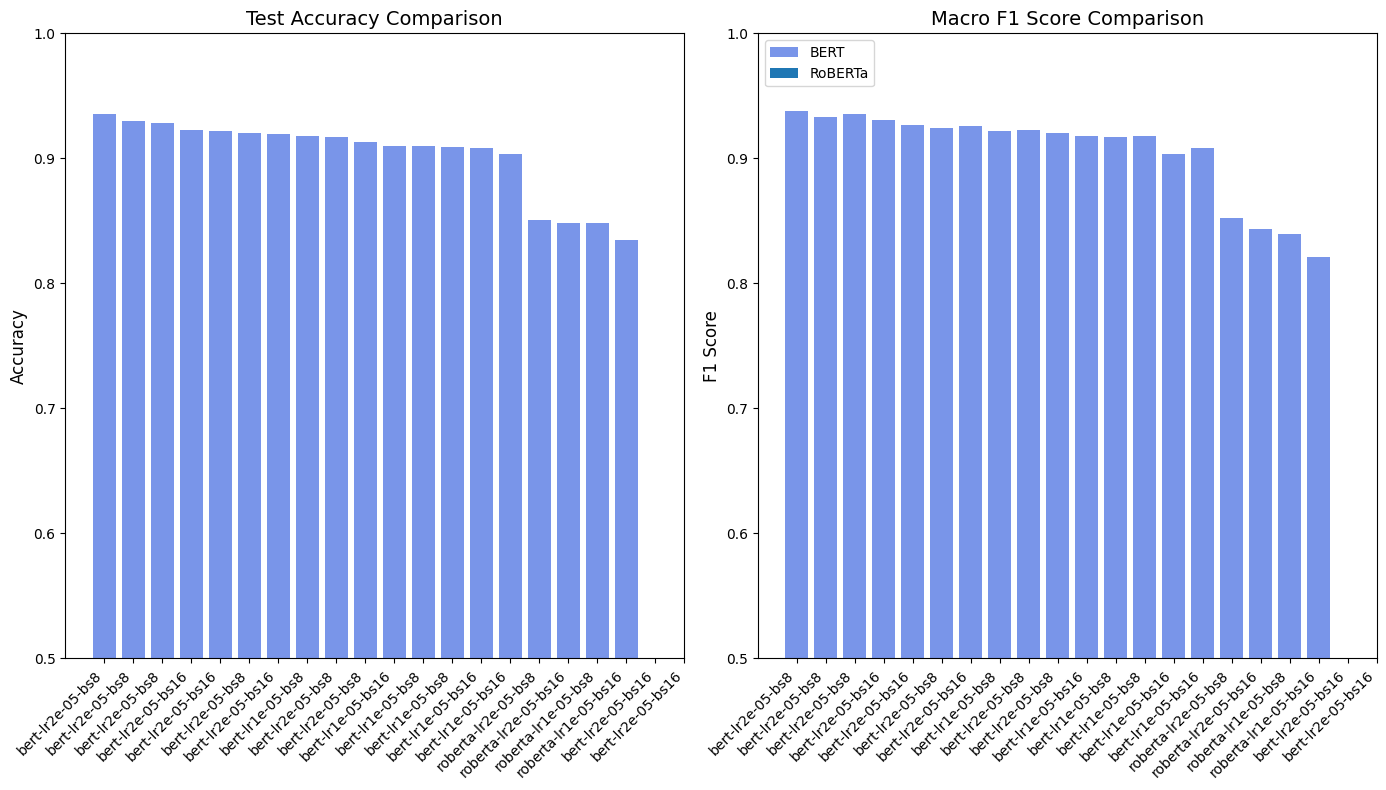

In [21]:
# Plot test accuracy comparison across models
plt.figure(figsize=(14, 8))

# Prepare data for plotting
model_types = []
accuracies = []
f1_scores = []
run_names = []

for _, run in runs_with_loss.iterrows():
    if run['tags.mlflow.runName'].startswith('bert-lr') or run['tags.mlflow.runName'].startswith('roberta-lr'):
        if 'metrics.test_accuracy' in run and 'metrics.test_macro_f1' in run:
            model_types.append('BERT' if 'bert' in run['tags.mlflow.runName'] else 'RoBERTa')
            accuracies.append(run['metrics.test_accuracy'])
            f1_scores.append(run['metrics.test_macro_f1'])
            run_names.append(run['tags.mlflow.runName'])

# Create DataFrame for easier plotting
results_df = pd.DataFrame({
    'Model': model_types,
    'Run': run_names,
    'Accuracy': accuracies,
    'F1 Score': f1_scores
})

# Sort by accuracy
results_df = results_df.sort_values('Accuracy', ascending=False)

# Bar plot
ax = plt.subplot(1, 2, 1)
bert_mask = results_df['Model'] == 'BERT'
roberta_mask = results_df['Model'] == 'RoBERTa'

# BERT bars
plt.bar(np.arange(bert_mask.sum()), results_df[bert_mask]['Accuracy'], color='royalblue', alpha=0.7)

# RoBERTa bars
plt.bar(np.arange(bert_mask.sum(), len(results_df)), results_df[roberta_mask]['Accuracy'], color='orange', alpha=0.7)

# Labels
plt.title('Test Accuracy Comparison', fontsize=14)
plt.ylabel('Accuracy', fontsize=12)
plt.xticks(np.arange(len(results_df)), results_df['Run'], rotation=45, ha='right')
plt.ylim(0.5, 1.0)  # Adjust as needed based on your results

# Add F1 score plot
ax = plt.subplot(1, 2, 2)

# BERT bars
plt.bar(np.arange(bert_mask.sum()), results_df[bert_mask]['F1 Score'], color='royalblue', alpha=0.7, label='BERT')

# RoBERTa bars
plt.bar(np.arange(bert_mask.sum(), len(results_df)), results_df[roberta_mask]['F1 Score'], color='orange', alpha=0.7, label='RoBERTa')

# Labels
plt.title('Macro F1 Score Comparison', fontsize=14)
plt.ylabel('F1 Score', fontsize=12)
plt.xticks(np.arange(len(results_df)), results_df['Run'], rotation=45, ha='right')
plt.ylim(0.5, 1.0)  # Adjust as needed based on your results
plt.legend()

plt.tight_layout()
plt.show()

In [22]:
# Create confusion matrices for each label (experiential dimension)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion Matrix', cmap=plt.cm.Blues):
    """
    Print and plot the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(6, 4))
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        fmt = '.2f'
    else:
        fmt = 'd'

    sns.heatmap(cm, annot=True, fmt=fmt, cmap=cmap, cbar=True, 
                xticklabels=classes, yticklabels=classes)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(title)
    plt.tight_layout()

# Get the best performing model based on F1 score
best_run_id = runs_with_loss.loc[runs_with_loss['metrics.test_macro_f1'].idxmax()].name

# Load predictions and true labels
try:
    # Try to get predictions directly from MLflow
    client = mlflow.tracking.MlflowClient()
    best_run = client.get_run(best_run_id)
    artifacts_uri = best_run.info.artifact_uri
    
    # Download predictions.npy artifact
    import os
    import tempfile
    import mlflow.artifacts
    
    with tempfile.TemporaryDirectory() as tmp_dir:
        predictions_path = mlflow.artifacts.download_artifacts(
            artifact_uri=f"{artifacts_uri}/predictions.npy",
            dst_path=tmp_dir
        )
        predictions = np.load(predictions_path)
        
        # Since we don't have direct access to the labels from artifacts,
        # we'll need to use the test set we have in memory
        true_labels = np.vstack([batch['labels'].numpy() for batch in DataLoader(test_dataset, batch_size=len(test_dataset))])
        
        # Get label names from your dataset
        label_names = [
            'Regenerative & Eco-Tourism',
            'Integrated Wellness',
            'Immersive Culinary',
            'Off-the-Beaten-Path Adventure'
        ]
        
        # Plot confusion matrix for each label
        plt.figure(figsize=(15, 10))
        for i, label_name in enumerate(label_names):
            plt.subplot(2, 2, i+1)
            cm = confusion_matrix(true_labels[:, i], predictions[:, i])
            plot_confusion_matrix(
                cm=cm,
                classes=['Negative', 'Positive'],
                title=f'Confusion Matrix for {label_name}'
            )
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.suptitle('Confusion Matrices for Each Experiential Dimension', fontsize=16)
        plt.show()
        
        # Print classification metrics for each label
        from sklearn.metrics import classification_report
        print("Classification metrics for each label:")
        for i, label_name in enumerate(label_names):
            print(f"\n{label_name}:")
            print(classification_report(true_labels[:, i], predictions[:, i], target_names=['Negative', 'Positive']))
except Exception as e:
    print(f"Error loading predictions: {e}")
    print("Please run a model first, or provide path to saved predictions.")
    
    # Fallback - if we have results from the previous cell run
    if 'results' in globals() and len(results) > 0:
        # Use the first result's predictions and labels
        predictions = results[0]['preds']
        true_labels = results[0]['labels']
        
        # Continue with plotting as before
        label_names = [
            'Regenerative & Eco-Tourism',
            'Integrated Wellness',
            'Immersive Culinary',
            'Off-the-Beaten-Path Adventure'
        ]
        
        plt.figure(figsize=(15, 10))
        for i, label_name in enumerate(label_names):
            plt.subplot(2, 2, i+1)
            cm = confusion_matrix(true_labels[:, i], predictions[:, i])
            plot_confusion_matrix(
                cm=cm,
                classes=['Negative', 'Positive'],
                title=f'Confusion Matrix for {label_name}'
            )
        plt.tight_layout()
        plt.subplots_adjust(top=0.9)
        plt.suptitle('Confusion Matrices for Each Experiential Dimension', fontsize=16)
        plt.show()
        
        # Print classification metrics for each label
        from sklearn.metrics import classification_report
        print("Classification metrics for each label:")
        for i, label_name in enumerate(label_names):
            print(f"\n{label_name}:")
            print(classification_report(true_labels[:, i], predictions[:, i], target_names=['Negative', 'Positive']))

Error loading predictions: expected string or bytes-like object, got 'int'
Please run a model first, or provide path to saved predictions.


## 4. Visualizing and Analyzing Specific Predictions

Let's examine specific examples of correct and incorrect predictions to gain qualitative insight into model performance.

In [23]:
# Load original text data to analyze predictions
import pandas as pd
import numpy as np
from transformers import AutoTokenizer
import torch
import textwrap
from IPython.display import display, HTML

# First try to load the original text data
try:
    # Load the original processed data
    df = pd.read_pickle('/content/drive/MyDrive/SerendipTravel/data/processed/tourism_reviews_processed.pkl')
except Exception as e:
    print(f"Could not load original data: {e}")
    # Create a mock dataframe if original data isn't available
    df = pd.DataFrame({
        'clean_text': [
            "this hotel was wonderful with great eco friendly practices and community engagement programs", 
            "beautiful spa retreat with yoga classes and meditation sessions by the beach", 
            "amazing food tour with authentic local cuisine and cooking classes", 
            "exciting hiking adventure through remote jungle trails and wildlife sightings"
        ]
    })

# Get tokenizer that matches the model we trained
try:
    model_name = "bert-base-uncased"  # or get this from the best run in MLflow
    tokenizer = AutoTokenizer.from_pretrained(model_name)
except Exception as e:
    print(f"Error loading tokenizer: {e}")
    tokenizer = None

# Function to get the original text for a given index in test_dataset
def get_original_text(idx, test_dataset, tokenizer, df):
    if tokenizer is None:
        return "Tokenizer not available"
    
    # Get the encoded input_ids from the test dataset
    input_ids = test_dataset[idx]['input_ids']
    
    # Decode the input_ids back to text
    decoded_text = tokenizer.decode(input_ids, skip_special_tokens=True)
    
    # Try to find the matching text in the original dataframe
    # This is an approximate match since tokenization can change the text
    closest_match = df[df['clean_text'].str.contains(decoded_text[:50], regex=False)]
    
    if len(closest_match) > 0:
        return closest_match.iloc[0]['clean_text']
    else:
        return decoded_text

# Function to find interesting examples
def find_interesting_examples(predictions, true_labels, test_dataset, tokenizer, df, label_names):
    results = {
        'perfectly_correct': [],  # All labels correct
        'partially_correct': [], # Some labels correct, some wrong
        'completely_wrong': [],  # All labels wrong
        'edge_cases': []         # Interesting patterns
    }
    
    # For each test example
    for i in range(len(predictions)):
        pred = predictions[i]
        true = true_labels[i]
        
        # Calculate correctness
        correct_labels = sum(pred[j] == true[j] for j in range(len(pred)))
        total_labels = len(pred)
        
        # Categorize the example
        if correct_labels == total_labels:
            if sum(true) > 0:  # Only include if it has at least one positive label
                results['perfectly_correct'].append(i)
        elif correct_labels == 0:
            results['completely_wrong'].append(i)
        else:
            results['partially_correct'].append(i)
            
        # Look for edge cases (examples with specific interesting patterns)
        # Case 1: Model predicts nothing but should have predicted something
        if sum(pred) == 0 and sum(true) > 0:
            results['edge_cases'].append((i, "Missed all positive labels"))
            
        # Case 2: Model predicts everything but should have been selective
        if sum(pred) == total_labels and sum(true) < total_labels:
            results['edge_cases'].append((i, "Over-predicted labels"))
    
    return results

# Function to display a prediction with analysis
def display_prediction(idx, predictions, true_labels, test_dataset, tokenizer, df, label_names):
    pred = predictions[idx]
    true = true_labels[idx]
    
    # Get the original text
    text = get_original_text(idx, test_dataset, tokenizer, df)
    
    # Format text for better readability
    wrapped_text = "<br>".join(textwrap.wrap(text, width=100))
    
    # Create HTML for better visualization
    html = f"""<div style='background-color: #f9f9f9; padding: 15px; border-radius: 5px;'>
        <h3>Review Text:</h3>
        <p>{wrapped_text}</p>
        <table style='width:100%; border-collapse: collapse;'>
            <tr style='background-color: #e0e0e0;'>
                <th style='padding: 8px; text-align: left; border: 1px solid #ddd;'>Experiential Dimension</th>
                <th style='padding: 8px; text-align: center; border: 1px solid #ddd;'>True Label</th>
                <th style='padding: 8px; text-align: center; border: 1px solid #ddd;'>Predicted Label</th>
                <th style='padding: 8px; text-align: center; border: 1px solid #ddd;'>Correct?</th>
            </tr>"""
    
    # Add each label's prediction status
    for i, label_name in enumerate(label_names):
        true_val = true[i]
        pred_val = pred[i]
        is_correct = true_val == pred_val
        
        # Set colors based on prediction correctness
        bg_color = "#c6ecc6" if is_correct else "#f8d7da"
        true_text = "Yes" if true_val == 1 else "No"
        pred_text = "Yes" if pred_val == 1 else "No"
        correct_text = "✓" if is_correct else "✗"
        
        html += f"""<tr style='background-color: {bg_color};'>
            <td style='padding: 8px; border: 1px solid #ddd;'>{label_name}</td>
            <td style='padding: 8px; text-align: center; border: 1px solid #ddd;'>{true_text}</td>
            <td style='padding: 8px; text-align: center; border: 1px solid #ddd;'>{pred_text}</td>
            <td style='padding: 8px; text-align: center; border: 1px solid #ddd;'>{correct_text}</td>
        </tr>"""
    
    html += """</table>
    </div>
    <br>"""
    
    return HTML(html)

# Use our functions if we have predictions
try:
    # Try to use predictions from the previous cells
    if 'predictions' in locals() and 'true_labels' in locals():
        # Define label names
        label_names = [
            'Regenerative & Eco-Tourism',
            'Integrated Wellness',
            'Immersive Culinary',
            'Off-the-Beaten-Path Adventure'
        ]
        
        # Find interesting examples
        examples = find_interesting_examples(predictions, true_labels, test_dataset, tokenizer, df, label_names)
        
        print(f"Found {len(examples['perfectly_correct'])} perfectly correct examples")
        print(f"Found {len(examples['partially_correct'])} partially correct examples")
        print(f"Found {len(examples['completely_wrong'])} completely wrong examples")
        print(f"Found {len(examples['edge_cases'])} interesting edge cases")
        
        # Display examples from each category
        categories = [
            ("Perfectly Correct Predictions", examples['perfectly_correct']),
            ("Partially Correct Predictions", examples['partially_correct']),
            ("Completely Wrong Predictions", examples['completely_wrong']),
            ("Interesting Edge Cases", [idx for idx, _ in examples['edge_cases']])
        ]
        
        for category_name, indices in categories:
            print(f"\n## {category_name}")
            
            # Display up to 3 examples from each category
            for i, idx in enumerate(indices[:3]):
                print(f"\n### Example {i+1}")
                display(display_prediction(idx, predictions, true_labels, test_dataset, tokenizer, df, label_names))
                
                # For edge cases, add the explanation
                if category_name == "Interesting Edge Cases":
                    for edge_idx, explanation in examples['edge_cases']:
                        if edge_idx == idx:
                            print(f"**Analysis:** {explanation}")
                            break
                
                # Provide some analysis based on the text and predictions
                text = get_original_text(idx, test_dataset, tokenizer, df)
                pred = predictions[idx]
                true = true_labels[idx]
                
                if category_name in ["Partially Correct Predictions", "Completely Wrong Predictions"]:
                    # Analyze potential reasons for errors
                    mismatched = [i for i in range(len(pred)) if pred[i] != true[i]]
                    
                    for label_idx in mismatched:
                        label_name = label_names[label_idx]
                        true_val = true[label_idx]
                        pred_val = pred[label_idx]
                        
                        if true_val == 1 and pred_val == 0:
                            # False negative analysis
                            print(f"**Missed {label_name}:** The model failed to identify this dimension despite relevant content.")
                            
                            # Look for keywords that might have been missed
                            keywords = {
                                'Regenerative & Eco-Tourism': ['eco', 'sustainable', 'community', 'local', 'organic', 'conservation'],
                                'Integrated Wellness': ['wellness', 'spa', 'yoga', 'meditation', 'relax', 'peaceful'],
                                'Immersive Culinary': ['food', 'cuisine', 'restaurant', 'cooking', 'taste', 'delicious'],
                                'Off-the-Beaten-Path Adventure': ['adventure', 'hiking', 'wildlife', 'nature', 'explore', 'remote']
                            }
                            
                            # Check for keywords in text
                            found_keywords = [kw for kw in keywords[label_name] if kw.lower() in text.lower()]
                            if found_keywords:
                                print(f"   Possible missed keywords: {', '.join(found_keywords)}")
                            else:
                                print(f"   No obvious keywords found - the theme might be implied rather than explicitly stated.")
                                
                        elif true_val == 0 and pred_val == 1:
                            # False positive analysis
                            print(f"**Incorrectly predicted {label_name}:** The model wrongly identified this dimension.")
                            
                            # Look for misleading keywords
                            keywords = {
                                'Regenerative & Eco-Tourism': ['eco', 'sustainable', 'community', 'local', 'organic', 'conservation'],
                                'Integrated Wellness': ['wellness', 'spa', 'yoga', 'meditation', 'relax', 'peaceful'],
                                'Immersive Culinary': ['food', 'cuisine', 'restaurant', 'cooking', 'taste', 'delicious'],
                                'Off-the-Beaten-Path Adventure': ['adventure', 'hiking', 'wildlife', 'nature', 'explore', 'remote']
                            }
                            
                            # Check for misleading keywords in text
                            misleading_keywords = [kw for kw in keywords[label_name] if kw.lower() in text.lower()]
                            if misleading_keywords:
                                print(f"   Possible misleading keywords: {', '.join(misleading_keywords)}")
                            else:
                                print(f"   No obvious misleading keywords - the language might have semantic similarities to this theme.")
    else:
        print("No predictions available. Run a model evaluation first.")
except Exception as e:
    print(f"Error analyzing predictions: {e}")
    print("Please run a model and generate predictions first.")


Could not load original data: [Errno 2] No such file or directory: '/content/drive/MyDrive/SerendipTravel/data/processed/tourism_reviews_processed.pkl'
No predictions available. Run a model evaluation first.
